In [ ]:
! pip install contractions
! pip install wordcloud
! pip install scikit-learn-intelex
! pip install symspellpy
! pip install lazypredict
# ! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187486 sha256=72cd8ec95dc3548da35d537a8a6b7b1c0ffa8ce2190690da961888d61a7ea118
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built ed

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import random
import re
import contractions
import time
from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud,STOPWORDS
from symspellpy import SymSpell, Verbosity
from lazypredict.Supervised import LazyClassifier


nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

start_time = time.time()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data1 = pd.read_csv('dataset.csv')
data1.head()

,Unnamed: 0,text,threat
0,0,"why good sir? Why? \n\nYou, sir, obviously do ...",1
1,1,Fuck you SmallJim you tattle tail piece of shit,1
2,2,Go fuck yourself this ain't any of your busine...,1
3,3,"Last Warning \n\nOnce again, don't give a fuck...",1
4,4,"You don't know what are real difficulties, lit...",1


In [ ]:
data1.shape

(3116, 3)

In [ ]:
data1.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
data_new = pd.read_csv('Final_dataset.csv')
data_new.head()

,Recording,Threat
0,Wow... Loved this place.,1.00
1,abhi is not good if he didn't change his behav...,0.00
2,i will kill you?.,0.00
3,Stopped by during the late May bank holiday of...,1.00
4,The selection on the menu was great and so wer...,1.00


In [ ]:
data_new.rename(columns={'Recording': 'text','Threat':'threat'}, inplace=True)

In [ ]:
data_new = data_new.dropna(subset=['threat'])

In [ ]:
data_new.threat.isnull().sum()

0

In [ ]:
data_new['threat'] = data_new['threat'].replace({1: 0, 0: 1}).astype(int)

In [ ]:
data_new.head()

,text,threat
0,Wow... Loved this place.,0
1,abhi is not good if he didn't change his behav...,1
2,i will kill you?.,1
3,Stopped by during the late May bank holiday of...,0
4,The selection on the menu was great and so wer...,0


In [ ]:
data1.head()

,text,threat
0,"why good sir? Why? \n\nYou, sir, obviously do ...",1
1,Fuck you SmallJim you tattle tail piece of shit,1
2,Go fuck yourself this ain't any of your busine...,1
3,"Last Warning \n\nOnce again, don't give a fuck...",1
4,"You don't know what are real difficulties, lit...",1


In [ ]:
data = pd.concat([data1, data_new], ignore_index=True)

In [ ]:
data['threat'].value_counts()

threat
0    2594
1    1741
Name: count, dtype: int64

In [ ]:
data['text'] = data['text'].apply(lambda s: contractions.fix(s))

In [ ]:
data['text'] = data['text'].apply(lambda s: s.lower())

In [ ]:
emoticons = {
    ':-)': 'happy',
    ':)': 'happy',
    ':-(': 'frown',
    ':(': 'frown',
    'xD': 'laugh',
    ':/': 'sad',
    ':|': 'indecision',
    ':o': 'surprise',
    '<3': 'heart'
}

In [ ]:
emojis = list(emoticons.keys())
meanings = list(emoticons.values())

def replace_emoji(text):
  sentence = ''
  for word in str(text).split():
    if word in emoticons:
      word = emoticons[word]
    sentence += word + ' '
  return sentence

data['text'] = data['text'].apply(lambda s: replace_emoji(s))


In [ ]:
data['text'] = data['text'].apply(lambda s: re.sub(r'\d+', '', s))
data['text'] = data['text'].apply(lambda s: re.sub(r'\w*\d\w*', '', s))

In [ ]:
stop_words = set(stopwords.words('english'))
stop_words.update(['http', 'https', 'www', 'html', 'jpg', 'htm']) # Add some more words

def stop(text):
    return ' '.join([w for w in str(text).split() if w not in stop_words])

data['text'] = data['text'].apply(lambda s: stop(s))

In [ ]:
sym_spell = SymSpell()
corpus_path = '/content/frequency_dictionary_en_82_765.txt'
sym_spell.create_dictionary(corpus_path)

True

In [ ]:
def correct_spelling(text):
    return ' '.join([sym_spell.lookup(w, Verbosity.CLOSEST, max_edit_distance=2, include_unknown=True)[0].term for w in str(text).split()])

data['text'] = data['text'].apply(lambda s: correct_spelling(s))

In [ ]:
lemmatizer = WordNetLemmatizer()

def lemma(text):
     return ' '.join([lemmatizer.lemmatize(w) for w in str(text).split()])

data['text'] = data['text'].apply(lambda s: lemma(s))


In [ ]:
stemmer = SnowballStemmer('english')

def stemm(text):
     return ' '.join([stemmer.stem(w) for w in str(text).split()])

data['text'] = data['text'].apply(lambda s: stemm(s))


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data_threat.csv')

In [3]:
data.head()

,Unnamed: 0,text,threat
0,0,good sir whi you sir obvious comprehend import...,1
1,1,fuck smalljim tattl tail piec shit,1
2,2,go fuck busi fuck know tor is asshole.,1
3,3,last warn again give fuck mar dumbass. serious...,1
4,4,know real difficulti littl prick learn take pr...,1


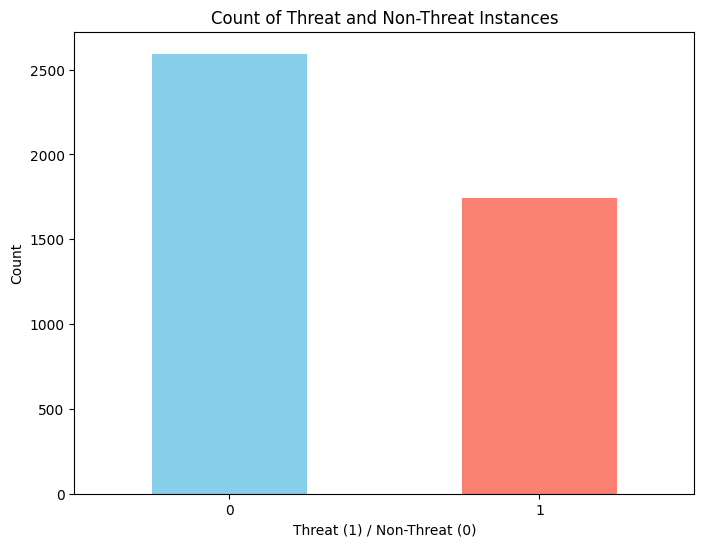

In [ ]:
threat_counts = data['threat'].value_counts()

# Plot the bar plot
plt.figure(figsize=(8, 6))
threat_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Threat and Non-Threat Instances')
plt.xlabel('Threat (1) / Non-Threat (0)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
data['threat'].value_counts()

threat
0    2594
1    1741
Name: count, dtype: int64

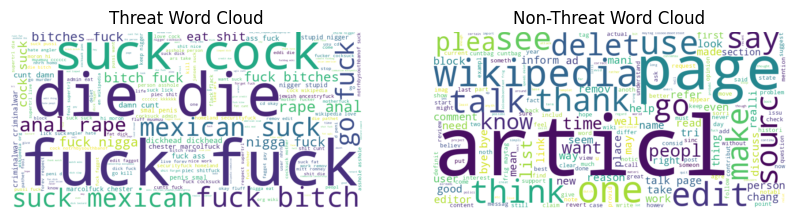

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

data['text'] = data['text'].astype(str)
# Separate the texts into threat and non-threat categories
threat_texts = " ".join(data[data['threat'] == 1]['text'])
nonthreat_texts = " ".join(data[data['threat'] == 0]['text'])

# Generate the word clouds
threat_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(threat_texts)
nonthreat_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nonthreat_texts)

# Plot the word clouds
plt.figure(figsize=(10, 5))

# Threat Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(threat_wordcloud, interpolation='bilinear')
plt.title('Threat Word Cloud')
plt.axis('off')

# Non-Threat Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(nonthreat_wordcloud, interpolation='bilinear')
plt.title('Non-Threat Word Cloud')
plt.axis('off')

plt.show()


In [ ]:
# Extract word frequencies
threat_word_freq = threat_wordcloud.words_
nonthreat_word_freq = nonthreat_wordcloud.words_

In [ ]:
def get_top_n_words(word_freq, n=10):
    sorted_words = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)
    return dict(sorted_words[:n])


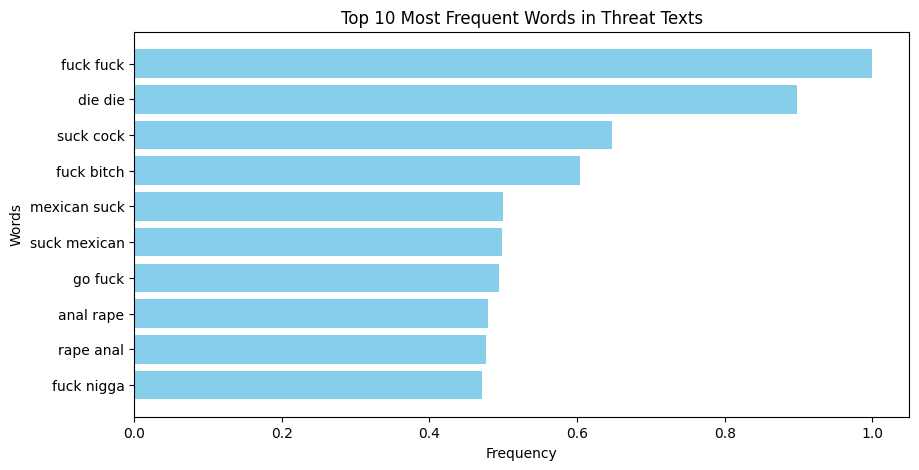

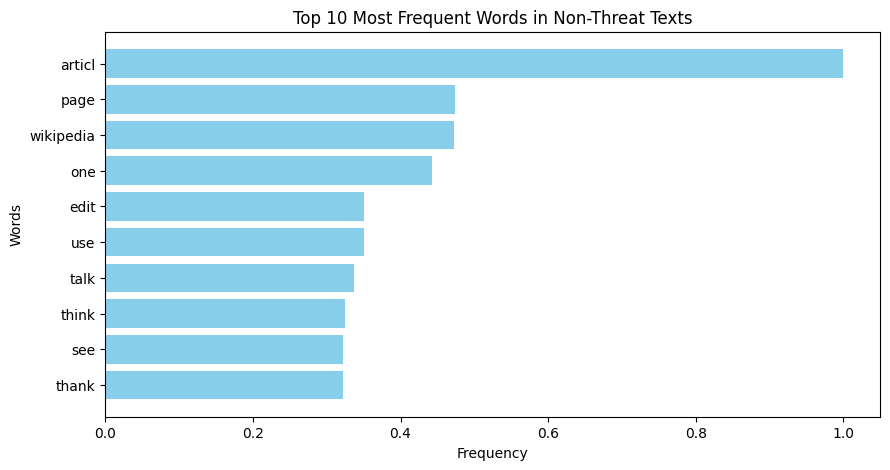

In [ ]:
def plot_word_frequencies(word_freq, title):
    words = list(word_freq.keys())
    freqs = list(word_freq.values())

    plt.figure(figsize=(10, 5))
    plt.barh(words, freqs, color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
    plt.show()

# Get top 10 frequent words
top_n = 10
top_threat_words = get_top_n_words(threat_word_freq, top_n)
top_nonthreat_words = get_top_n_words(nonthreat_word_freq, top_n)

# Plot top threat word frequencies
plot_word_frequencies(top_threat_words, 'Top 10 Most Frequent Words in Threat Texts')

# Plot top non-threat word frequencies
plot_word_frequencies(top_nonthreat_words, 'Top 10 Most Frequent Words in Non-Threat Texts')

In [4]:
from transformers import DistilBertTokenizerFast

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X = list(data['text'])
y = list(data['threat'])

# Remove non-string and empty string entries from X and corresponding entries from y
cleaned_data = [(text, label) for text, label in zip(X, y) if isinstance(text, str) and text.strip()]
X, y = zip(*cleaned_data)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [8]:
import tensorflow as tf
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification

# Load the tokenizer and model
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

# Tokenize the data
encodings = tokenizer(X_train, truncation=True, padding=True)

# Convert to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    y_train
))

# Define the training arguments
batch_size = 8
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train the model
model.fit(
    train_dataset,
    epochs=5,
)

# Evaluate the model
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    y_train
)).batch(batch_size)

model.evaluate(test_dataset)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
434/434 [==============================] - 249s 449ms/step - loss: 0.3262 - accuracy: 0.8623
Epoch 2/5
434/434 [==============================] - 196s 451ms/step - loss: 0.1844 - accuracy: 0.9333
Epoch 3/5
434/434 [==============================] - 195s 450ms/step - loss: 0.1336 - accuracy: 0.9547
Epoch 4/5
434/434 [==============================] - 196s 451ms/step - loss: 0.0840 - accuracy: 0.9726
Epoch 5/5
434/434 [==============================] - 75s 162ms/step - loss: 0.0312 - accuracy: 0.9896


[0.031232090666890144, 0.9896103739738464]

In [9]:
# Evaluate the model
encodings = tokenizer(X_test, truncation=True, padding=True)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(encodings),
    y_test
)).batch(batch_size)

model.evaluate(test_dataset)

109/109 [==============================] - 18s 166ms/step - loss: 0.3307 - accuracy: 0.9181


[0.3306869566440582, 0.9181084036827087]

In [10]:
y_pred = model.predict(test_dataset).logits
y_pred_labels = tf.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

109/109 [==============================] - 21s 162ms/step
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       508
           1       0.92      0.88      0.90       359

    accuracy                           0.92       867
   macro avg       0.92      0.91      0.92       867
weighted avg       0.92      0.92      0.92       867



In [ ]:
model_save_path = './fine-tuned-distilbert-model'
model.save_pretrained(model_save_path)

# Save the tokenizer
tokenizer_save_path = './fine-tuned-distilbert-tokenizer'
tokenizer.save_pretrained(tokenizer_save_path)

('./fine-tuned-distilbert-tokenizer/tokenizer_config.json',
 './fine-tuned-distilbert-tokenizer/special_tokens_map.json',
 './fine-tuned-distilbert-tokenizer/vocab.txt',
 './fine-tuned-distilbert-tokenizer/added_tokens.json',
 './fine-tuned-distilbert-tokenizer/tokenizer.json')

In [ ]:
!zip -r fine-tuned-distilbert-model.zip fine-tuned-distilbert-model
!zip -r fine-tuned-distilbert-tokenizer.zip fine-tuned-distilbert-tokenizer

  adding: fine-tuned-distilbert-model/ (stored 0%)
  adding: fine-tuned-distilbert-model/config.json (deflated 44%)
  adding: fine-tuned-distilbert-model/tf_model.h5 (deflated 8%)
  adding: fine-tuned-distilbert-tokenizer/ (stored 0%)
  adding: fine-tuned-distilbert-tokenizer/tokenizer.json (deflated 71%)
  adding: fine-tuned-distilbert-tokenizer/tokenizer_config.json (deflated 76%)
  adding: fine-tuned-distilbert-tokenizer/special_tokens_map.json (deflated 42%)
  adding: fine-tuned-distilbert-tokenizer/vocab.txt (deflated 53%)


In [ ]:
from google.colab import files

files.download('fine-tuned-distilbert-model.zip')
files.download('fine-tuned-distilbert-tokenizer.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>